In [48]:
#!pip install ydata-synthetic
#https://colab.research.google.com/github/ydataai/ydata-synthetic/blob/master/examples/timeseries/TimeGAN_Synthetic_stock_data.ipynb#scrollTo=tw63DsLXhfYo

In [ ]:
#!pip install statsmodels
#!pip install chowtest

  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/9a/1c/2e10b7c7cc44fa418272996bf0427b8016718fd62f995d9c1f7ab37adf35/statsmodels-0.14.6-cp310-cp310-win_amd64.whl.metadata
  Using cached statsmodels-0.14.6-cp310-cp310-win_amd64.whl.metadata (9.8 kB)
Using cached statsmodels-0.14.6-cp310-cp310-win_amd64.whl (9.6 MB)



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import acovf
from statsmodels.tsa.stattools import adfuller

ModuleNotFoundError: No module named 'pandas'

In [50]:
# Specific to TimeGANs
seq_len = 24
n_seq = 1
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
# For quick prototyping
# epochs=50000
epochs = 2000

gan_args = ModelParameters(
    batch_size=batch_size, lr=learning_rate, noise_dim=noise_dim, layers_dim=dim
)

train_args = TrainParameters(
    epochs=epochs, sequence_length=seq_len, number_sequences=n_seq
)

In [51]:
wti_df = pd.read_csv('../data/wti_prices.csv', index_col=0, parse_dates=['Date'])
cols = list(wti_df.columns)
print(wti_df.shape)
print(cols)

(481, 1)
['WTI_price']


In [52]:
wti_df = np.log(wti_df).diff().dropna()
scaler = MinMaxScaler().fit(wti_df)

In [53]:
if path.exists("synthesizer_wti.pkl"):
    synth = TimeSeriesSynthesizer.load("synthesizer_wti.pkl")
else:
    synth = TimeSeriesSynthesizer(modelname="timegan", model_parameters=gan_args)
    synth.fit(wti_df, train_args, num_cols=cols)
    synth.save("synthesizer_wti.pkl")

In [54]:
stock_data_blocks = processed_stock(path='../data/wti_prices.csv', seq_len=seq_len)
synth_data = np.asarray(synth.sample(len(stock_data_blocks)))
synth_data = scaler.inverse_transform(synth_data.reshape(-1, synth_data.shape[-1])).reshape(synth_data.shape)
print(synth_data.shape)

(457, 24, 1)


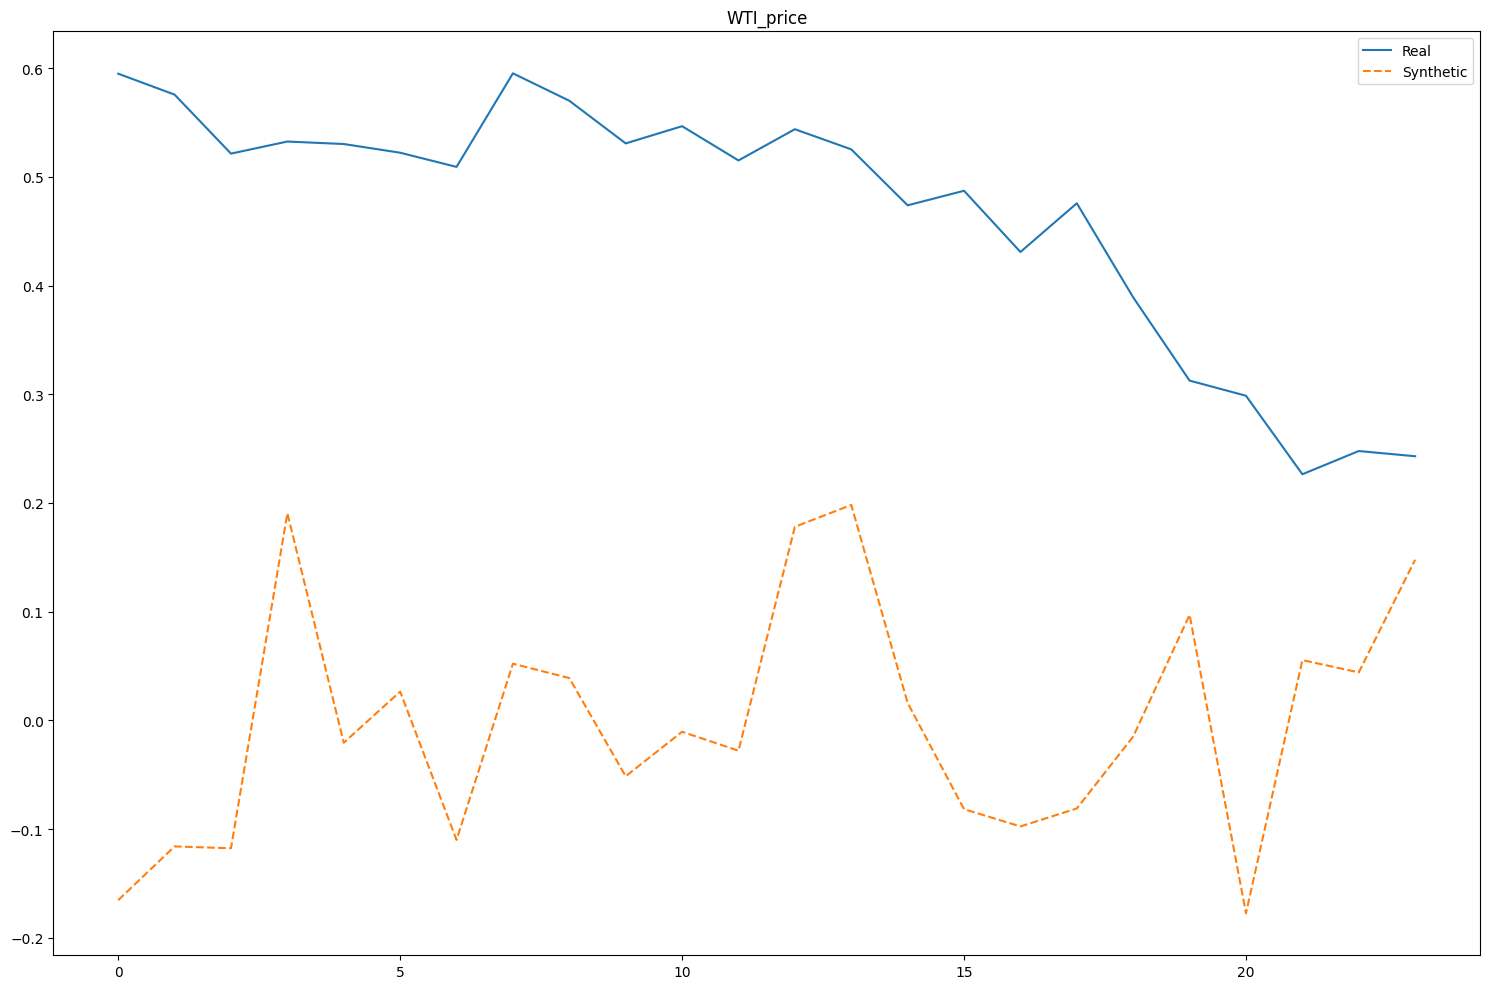

In [55]:
#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(figsize=(15, 10))

time = list(range(1,25))
obs = np.random.randint(len(stock_data_blocks))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data_blocks[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes,
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

# PCA and tSNE analysis to show similarity of generated output

In [56]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 100
idx = np.random.permutation(len(stock_data_blocks))[:sample_size]

real_sample = np.asarray(stock_data_blocks)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

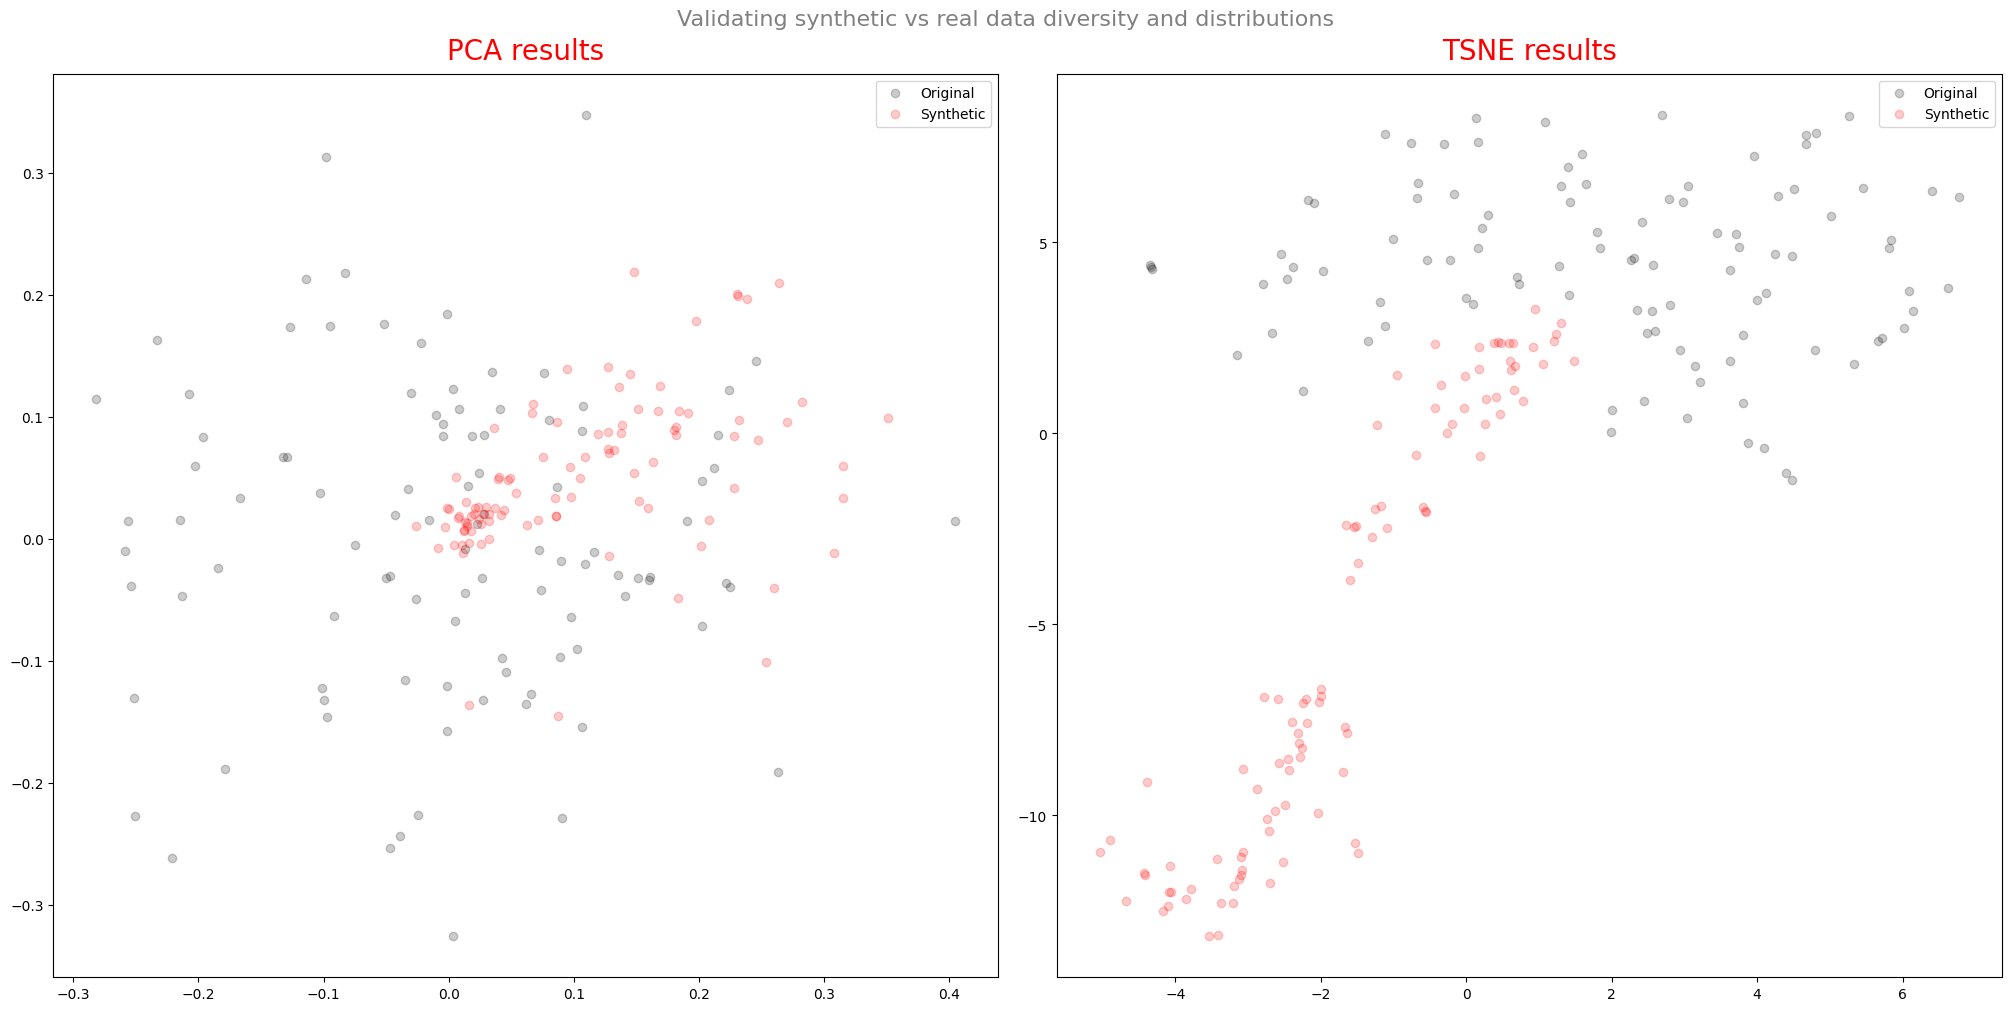

In [57]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

# Underlying KDE

Looks similar but the tails

c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

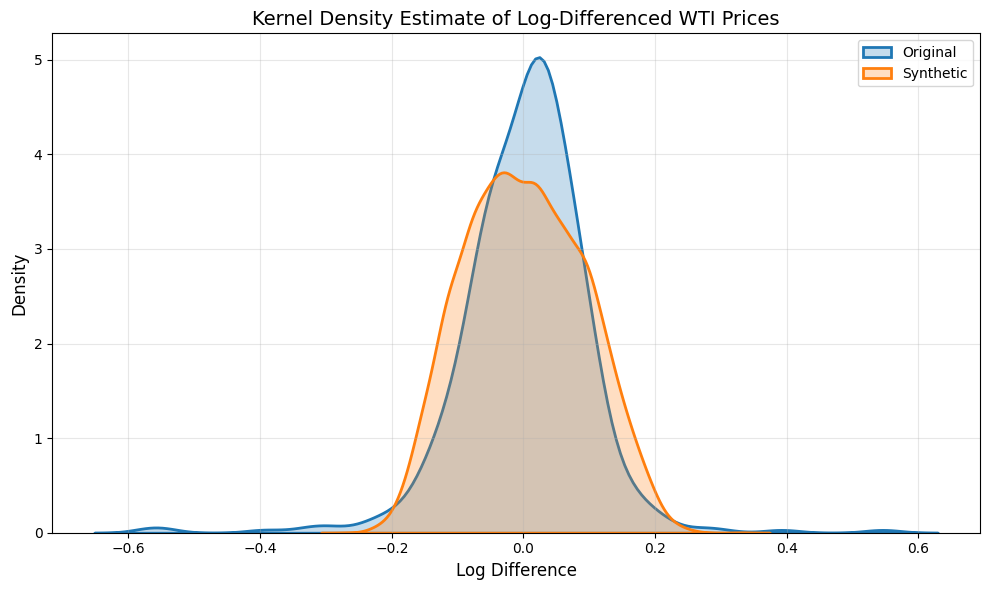

In [61]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=wti_df['WTI_price'], fill=True, linewidth=2)
sns.kdeplot(data=synth_data.reshape(-1), fill=True, linewidth=2)
plt.title('Kernel Density Estimate of Log-Differenced WTI Prices', fontsize=14)
plt.xlabel('Log Difference', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(['Original', 'Synthetic'])
plt.tight_layout()
plt.show()

# 1st Autocovariance

Interestingly, the real 2 year seqeuences have autocorrelation near 0, but autocorrelation on whole data is.0023, maybe look at autocorrelation instead?

In [59]:
# First (lag-1) autocovariance for each row of synth_data
def lag1_autocovariance(seq):
    """Compute lag-1 autocovariance: Cov(x_t, x_{t-1})"""
    x = seq.flatten()
    mu = x.mean()
    return np.mean((x[1:] - mu) * (x[:-1] - mu))

synth_acov = [lag1_autocovariance(synth_data[i]) for i in range(len(synth_data))]
print(f"Number of samples: {len(synth_acov)}")
print(f"First 5 values: {synth_acov[:5]}")
acov_original = [lag1_autocovariance(stock_data_blocks[i]) for i in range(len(stock_data_blocks))]

Number of samples: 457
First 5 values: [0.002220294, 0.0005732199, 0.0012283842, 0.00011384394, 0.0020264783]


In [71]:
lag1_autocovariance(wti_df['WTI_price'].values)

0.002376211800951272

c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

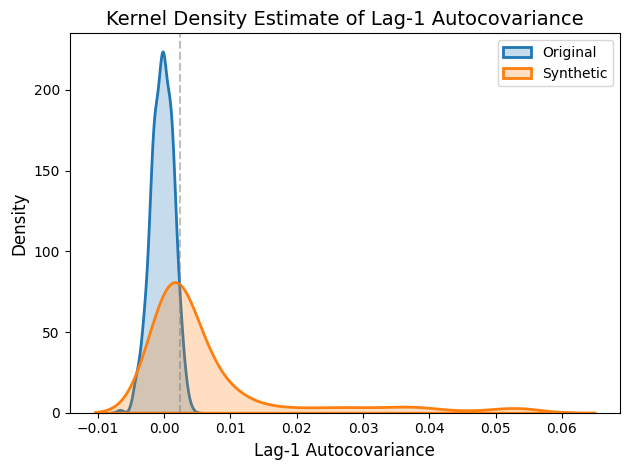

In [64]:
sns.kdeplot(synth_acov, fill=True, linewidth=2)
sns.kdeplot(acov_original, fill=True, linewidth=2)
plt.title('Kernel Density Estimate of Lag-1 Autocovariance', fontsize=14)
plt.legend(['Original', 'Synthetic'])
plt.xlabel('Lag-1 Autocovariance', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.axvline(lag1_autocovariance(wti_df['WTI_price'].values), color='grey', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Outlier analysis

Evidently the tails are not fat enough

In [70]:
synth_data_reshaped = synth_data.reshape(-1, synth_data.shape[-1])
print(f"Percentage of values less than -0.2 in synthetic data: {(synth_data_reshaped<-.2).mean()*100:.2f}%")
print(f"Percentage of positive values in synthetic data: {(synth_data_reshaped>0).mean()*100:.2f}%")
print(f"Percentage of values greater than 0.2 in synthetic data: {(synth_data_reshaped>.2).mean()*100:.2f}%")

print(f"Percentage of values less than -0.2 in original data: {(wti_df['WTI_price']<-.2).mean()*100:.2f}%")
print(f"Percentage of positive values in original data: {(wti_df['WTI_price']>0).mean()*100:.2f}%")
print(f"Percentage of values greater than 0.2 in original data: {(wti_df['WTI_price']>.2).mean()*100:.2f}%")


Percentage of values less than -0.2 in synthetic data: 0.32%
Percentage of positive values in synthetic data: 49.39%
Percentage of values greater than 0.2 in synthetic data: 0.81%
Percentage of values less than -0.2 in original data: 2.29%
Percentage of positive values in original data: 55.62%
Percentage of values greater than 0.2 in original data: 1.67%


# Stationarity test and Structural Break

ADF p-value: 0.0000


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


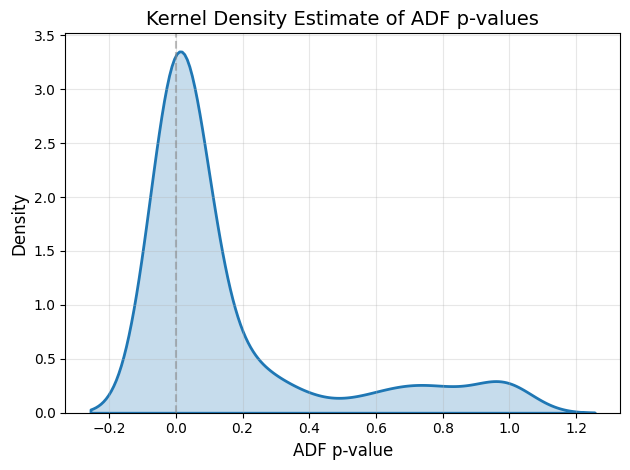

In [81]:
##ADF test for stationarity for synthetic data
adf_result = adfuller(wti_df['WTI_price'].values)
print(f"ADF p-value: {adf_result[1]:.4f}")

adf = []
for row in synth_data:
    adf_result = adfuller(row.flatten())
    adf.append(adf_result[1])

sns.kdeplot(adf, fill=True, linewidth=2)
plt.title('Kernel Density Estimate of ADF p-values', fontsize=14)
plt.xlabel('ADF p-value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(adfuller(wti_df['WTI_price'].values)[1], color='grey', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [88]:
from chow_test import chowtest


ImportError: cannot import name 'chowtest' from 'chow_test' (c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\chow_test\__init__.py)

In [4]:
# === Self-contained TimeGAN training cell ===
# Fix for slow Adam optimizer on M1/M2 Macs - MUST be before TensorFlow import
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Imports
from os import path
import pandas as pd
import numpy as np
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer

# TimeGAN hyperparameters
seq_len_long = 180  # 15 years = 180 months
n_seq = 1
noise_dim = 32
dim = 128
batch_size = 128
learning_rate = 5e-4
epochs = 100 # Reduce to 500-1000 for faster prototyping

gan_args_long = ModelParameters(
    batch_size=batch_size, lr=learning_rate, noise_dim=noise_dim, layers_dim=dim
)

train_args_long = TrainParameters(
    epochs=epochs, sequence_length=seq_len_long, number_sequences=n_seq
)

# Load and process data
wti_df_raw = pd.read_csv('../data/wti_prices.csv', index_col=0, parse_dates=['Date'])
cols = list(wti_df_raw.columns)
wti_df_log_returns = np.log(wti_df_raw).diff().dropna()
print(f"Log returns shape: {wti_df_log_returns.shape}")
print(f"Training windows: {len(wti_df_log_returns) - seq_len_long + 1}")

# Train TimeGAN
if path.exists("synthesizer_wti_15yr.pkl"):
    synth_long = TimeSeriesSynthesizer.load("synthesizer_wti_15yr.pkl")
    print("Loaded existing model")
else:
    synth_long = TimeSeriesSynthesizer(modelname="timegan", model_parameters=gan_args_long)
    synth_long.fit(wti_df_log_returns, train_args_long, num_cols=cols)
    synth_long.save("synthesizer_wti_15yr.pkl")
    print(f"Trained TimeGAN with sequence length: {seq_len_long} months (15 years)")

Log returns shape: (480, 1)
Training windows: 301
A DataProcessor is not available for the TimeGAN.


Joint networks training: 100%|██████████| 100/100 [58:27<00:00, 35.08s/it]   

Trained TimeGAN with sequence length: 180 months (15 years)



/Users/bytedance/Desktop/nus code/dse4101-project/.venv/lib/python3.10/site-packages/tensorflow/python/keras/utils/generic_utils.py:486: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [7]:
# === Self-contained generation cell ===
import pandas as pd
import numpy as np

# Generate 10 synthetic 15-year sequences and save to CSV
num_samples = 10

synth_data_long = synth_long.sample(num_samples)
synth_data_long = np.asarray(synth_data_long)  # Ensure NumPy array for correct indexing
print(f"Generated {num_samples} synthetic sequences")
print(f"Shape: {synth_data_long.shape}")  # Should be (10, 180, 1)

# Convert to DataFrame - each sample is 1 column (180 rows = 180 months)
synthetic_df = pd.DataFrame()
for i in range(num_samples):
    synthetic_df[f"sample_{i+1}"] = synth_data_long[i, :, 0]

# Save to CSV
synthetic_df.to_csv('../data/synthetic_wti_15yr.csv', index=False)
print(f"\nSynthetic log returns saved to: ../data/synthetic_wti_15yr.csv")
print(f"Shape: {synthetic_df.shape}")  # (180 rows, 10 columns)
print(f"\nFirst 5 rows:\n{synthetic_df.head()}")


Generated 10 synthetic sequences
Shape: (10, 180, 1)

Synthetic log returns saved to: ../data/synthetic_wti_15yr.csv
Shape: (180, 10)

First 5 rows:
   sample_1  sample_2  sample_3  sample_4  sample_5  sample_6  sample_7  \
0  0.546375  0.548041  0.544946  0.528788  0.548058  0.551262  0.547550   
1  0.513847  0.516641  0.500619  0.441270  0.508923  0.535297  0.524638   
2  0.524256  0.520927  0.503322  0.447546  0.505836  0.549930  0.559994   
3  0.480836  0.494967  0.511987  0.563206  0.476474  0.466730  0.549521   
4  0.393336  0.432560  0.512589  0.658096  0.452526  0.337143  0.418552   

   sample_8  sample_9  sample_10  
0  0.529859  0.538588   0.552513  
1  0.469276  0.485031   0.518997  
2  0.511281  0.496820   0.508989  
3  0.595115  0.522891   0.462312  
4  0.630329  0.556758   0.414861  
